In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
indx = np.load("anstey/indexes.npy")

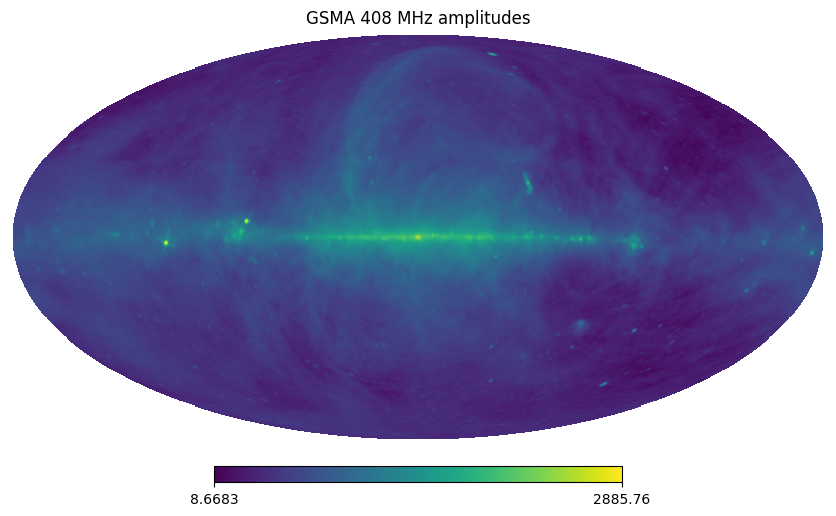

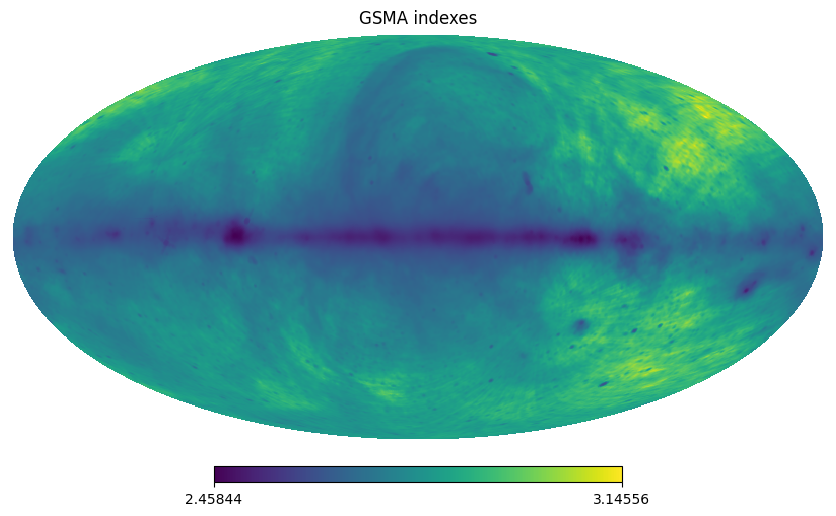

In [3]:
hp.mollview(indx[0], title="GSMA 408 MHz amplitudes", norm='log')
plt.show()
hp.mollview(indx[1], title="GSMA indexes")
plt.show()

# REALLY WEIRD HEALPIX BUG - MAXIMUM VALUE OF COLORBAR DOESN'T REFLECT MAXIMUM PIXEL VALUE???

# HOW TO INTERPRET POWER LAW PIXEL REGIONS WITH A SMALLER NSIDE MAP - DEGRADE GDSM 408 AND 230 MAPS TO LOWER NSIDE FIRST, THEN GENERATE ANALAGOUS GSMA MAP? OR IS THERE SOME WAY TO KEEP THE CURRENT NSIDE MAP AND ENCODE IT IN OUR MODEL?

[2.45808092 2.59557674 2.73307255 2.87056837 3.00806418 3.14556   ]


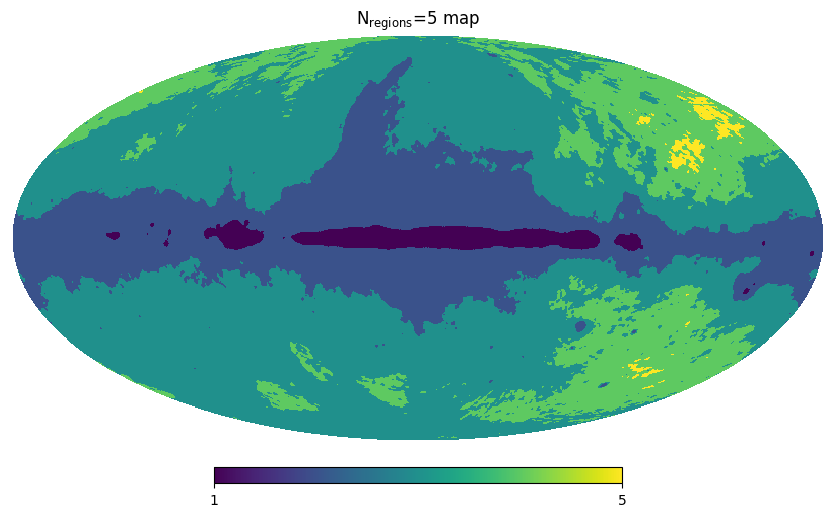

In [4]:
Nregions = 5
max_indx = 3.14556#np.max(indx[1])
min_indx = np.min(indx[1])
indx_range = np.linspace(min_indx, max_indx, Nregions+1)
print(indx_range)
# Find all pixels which 
masks = []
for i in range(len(indx_range)-1):
    mask = []
    range_tuple = (indx_range[i], indx_range[i+1])
    for j in range(len(indx[1])):
        if indx[1,j] > range_tuple[0] and indx[1,j] < range_tuple[1]:
            mask.append(j)
    masks.append(mask)
mask_maps = []
for mask in masks:
    mask_map = np.zeros(len(indx[1]))
    mask_map[mask] = 1.
    mask_maps.append(mask_map)
mask_visualisation = np.sum([(i+1)*mask_maps[i] for i in range(Nregions)], axis=0)
hp.mollview(mask_visualisation, title=r"N$_\mathrm{regions}$="+f"{Nregions} map")

Text(0.5, 1.0, 'temperature > 2885.76')

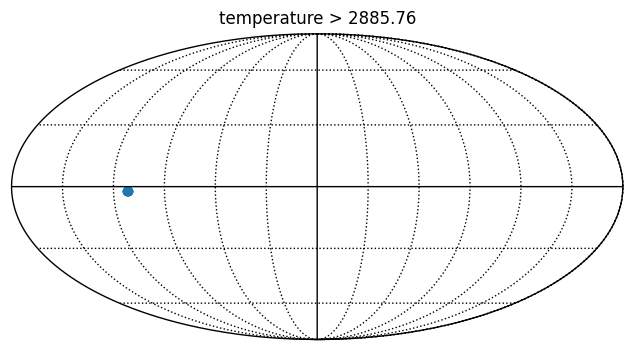

In [5]:
count = np.where(indx[0]>2885.76, True, False)
count_pos = np.array([i for i in range(len(count)) if count[i]])
count_pos = hp.pix2ang(nside=512, ipix=count_pos)
hp.graticule()
hp.projscatter(*count_pos)
plt.title("temperature > 2885.76")

# Pixel mask beam convolutions

Two approaches in notes. Let's look at the full->degraded map approach first.

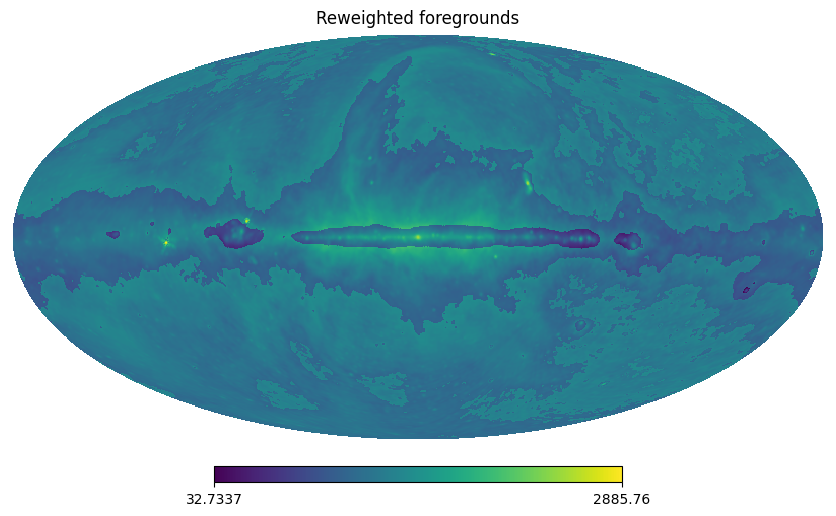

In [19]:
reweightings = [a**2 for a in range(1,Nregions+1)]
newmap = np.sum([reweightings[i]*mask_maps[i]*indx[0] for i in range(Nregions)], axis=0)
hp.mollview(newmap, norm='log', title='Reweighted foregrounds')

In [41]:
import src.beam_functions as BF
import src.spherical_harmonics as SH
reload(BF)

<module 'src.beam_functions' from '/Users/yordani/Documents/boosted_compass/matrix-observer/src/beam_functions.py'>

In [8]:
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)
beam_alm = BF.calc_blm(nside=512, lmax=1024, beam_use=narrow_cosbeam)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


In [42]:
map_alm = hp.map2alm(newmap, lmax=1024)
beam_vec = BF.calc_beam_vector(nside=512, lmax=1024, beam_use=narrow_cosbeam)
beam_convolved_alm = beam_vec*SH.RealSphericalHarmonics().complex2RealALM(map_alm)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


In [43]:
convolved_map = hp.alm2map(SH.RealSphericalHarmonics().real2ComplexALM(beam_convolved_alm), nside=512)

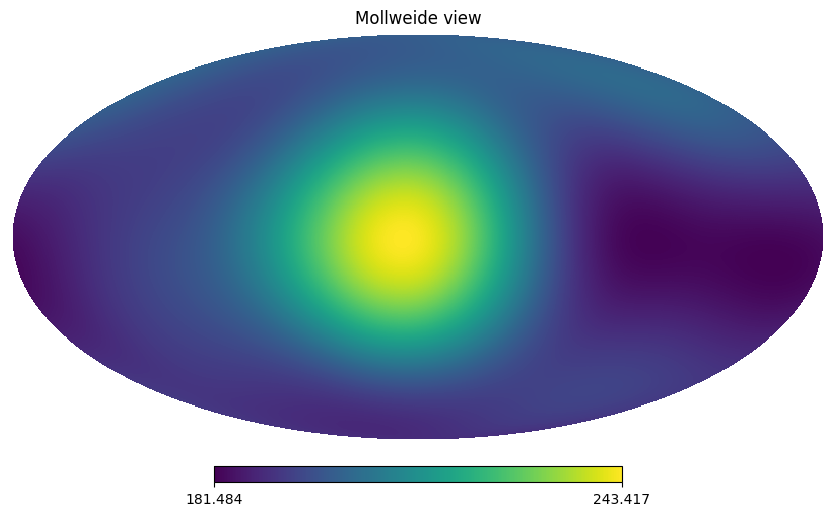

In [44]:
hp.mollview(convolved_map)

In [6]:
import src.sky_models as SM
import src.spherical_harmonics as SH
import healpy as hp

3072 561


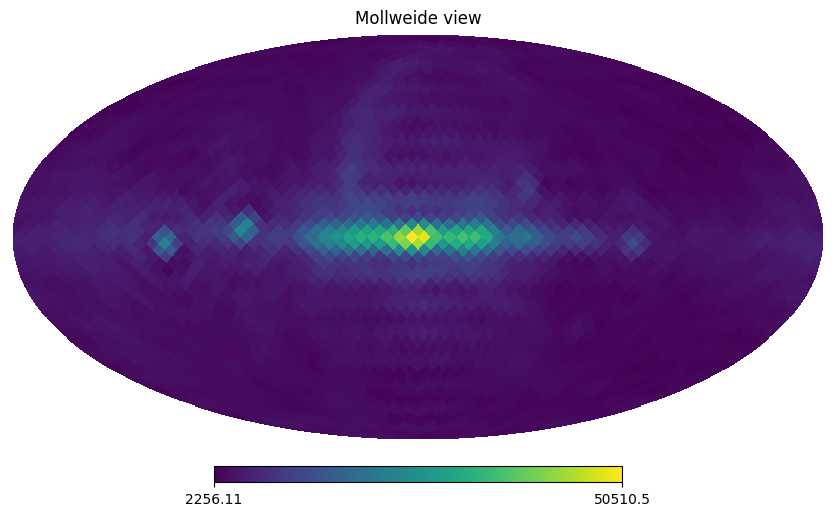

3072 561


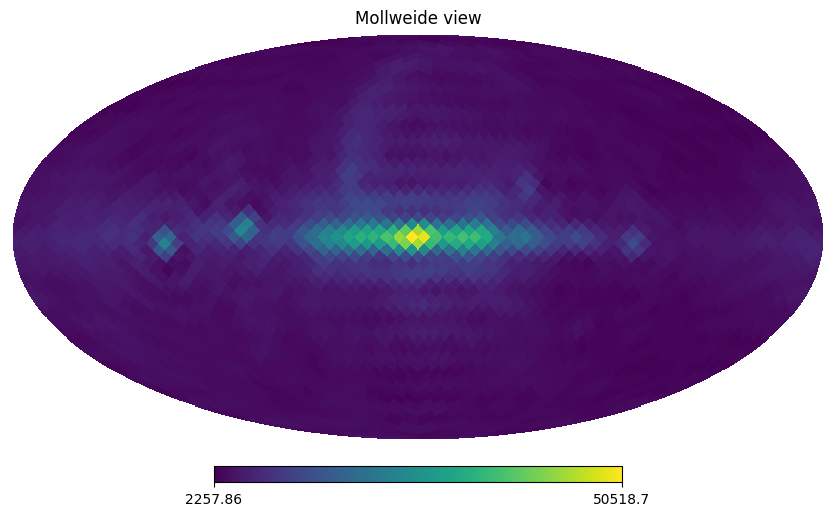

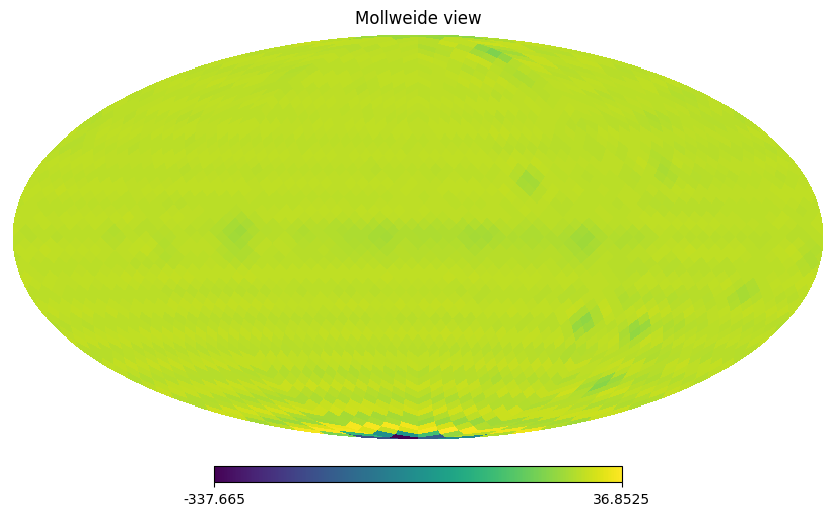

In [10]:
gsma_lo = SH.calc_spherical_harmonic_matrix(nside=16, lmax=32) @ SM.foreground_gsma_alm_nsidelo(nu=60)
hp.mollview(gsma_lo)
plt.show()

gsma_degraded = SH.calc_spherical_harmonic_matrix(nside=16, lmax=32) @ SM.foreground_gsma_alm(nu=60, lmax=32, nside=16)
hp.mollview(gsma_degraded)
plt.show()

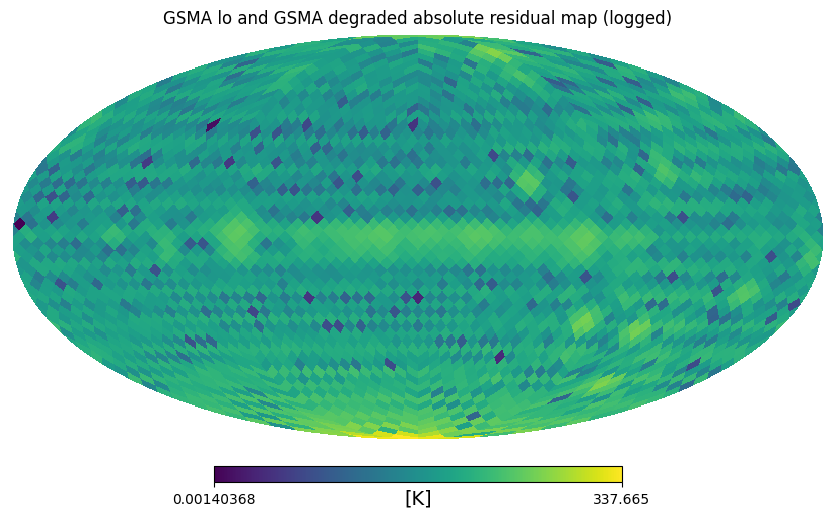

Text(0.5, 0, 'GSMA lo and GSMA degraded abs residuals [K]')

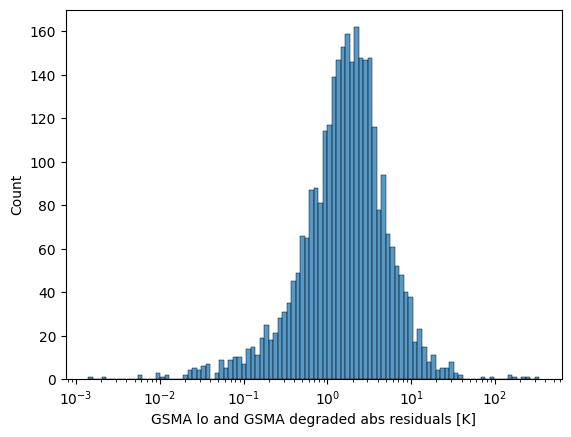

In [25]:
import seaborn as sns
hp.mollview(abs(gsma_lo-gsma_degraded), norm='log', title="GSMA lo and GSMA degraded absolute residual map (logged)", unit='[K]')
plt.show()
sns.histplot(abs(gsma_lo-gsma_degraded), bins=100, log_scale=10)
plt.xlabel("GSMA lo and GSMA degraded abs residuals [K]")


## Repeat Nregions analysis for the GSMA lo map.

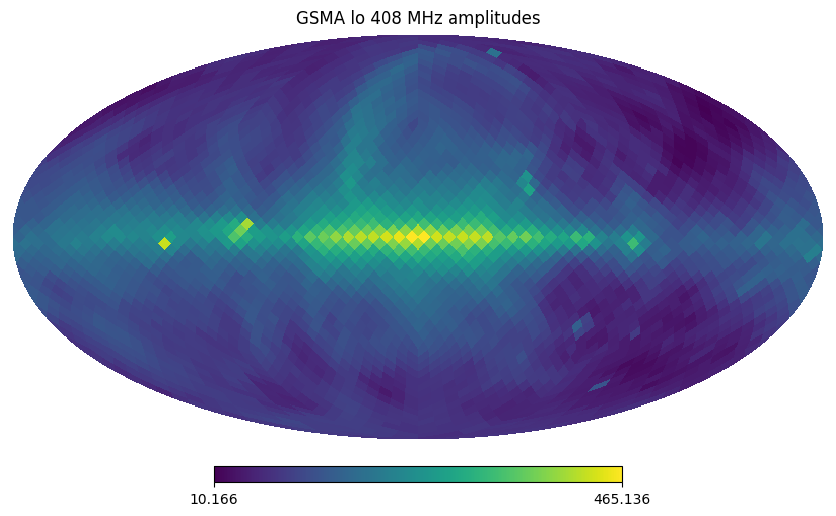

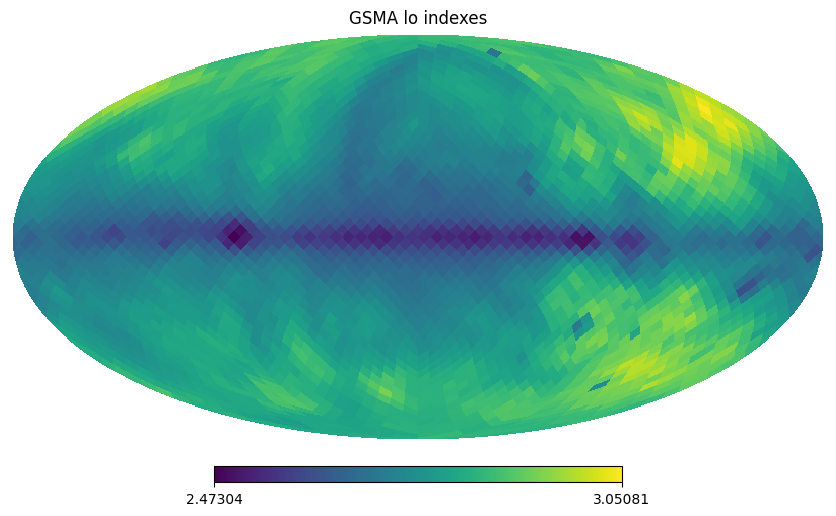

In [30]:
indx = np.load("anstey/indexes_16.npy")
hp.mollview(indx[0], title="GSMA lo 408 MHz amplitudes", norm='log')
plt.show()
hp.mollview(indx[1], title="GSMA lo indexes")
plt.show()

[2.47304   2.6174825 2.761925  2.9063675 3.05081  ]


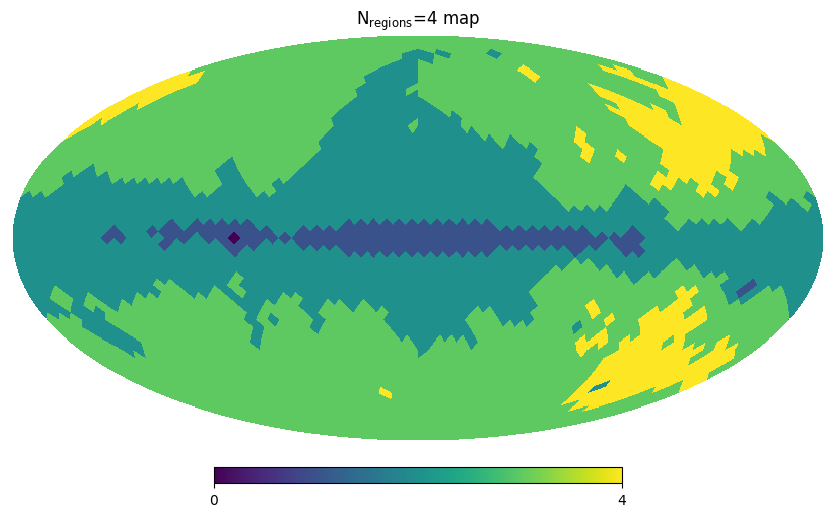

In [32]:
Nregions = 4
max_indx = 3.05081#np.max(indx[1])
min_indx = 2.47304
indx_range = np.linspace(min_indx, max_indx, Nregions+1)
print(indx_range)
# Find all pixels which 
masks = []
for i in range(len(indx_range)-1):
    mask = []
    range_tuple = (indx_range[i], indx_range[i+1])
    for j in range(len(indx[1])):
        if indx[1,j] > range_tuple[0] and indx[1,j] < range_tuple[1]:
            mask.append(j)
    masks.append(mask)
mask_maps = []
for mask in masks:
    mask_map = np.zeros(len(indx[1]))
    mask_map[mask] = 1.
    mask_maps.append(mask_map)
mask_visualisation = np.sum([(i+1)*mask_maps[i] for i in range(Nregions)], axis=0)
hp.mollview(mask_visualisation, title=r"N$_\mathrm{regions}$="+f"{Nregions} map")